In [78]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import matplotlib.pylab as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(16.7,8.27)})

/home/aggelos-i3/.conda/envs/tf-cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [79]:
LOOKBACK = 4

In [80]:
def series_to_supervised(sequence, lookback, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + lookback
        if end_ix > len(sequence) - 1:
            break

        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [81]:
df_0 = pd.read_csv("7hnz0037.csv")
df_0 = df_0[['loc. (actual) [km]', 'voltage [V]']]
df_0 = df_0.set_index('loc. (actual) [km]')
df_0.sort_index(inplace=True)


In [82]:
scaler = MinMaxScaler()

In [83]:
df_scaled = scaler.fit_transform(df_0)

In [84]:
X, y = series_to_supervised(df_scaled, LOOKBACK, 1)

In [92]:
inputs = Input(shape=X.shape[1:])
x =GRU(128, return_sequences=True)(inputs)
x = GRU(128)(x)
out = Dense(1)(x)

model = Model(inputs, out)
model.compile(loss='mae', optimizer='adam')
model.fit(X, y, epochs=50, validation_split=0.1)

Train on 898 samples, validate on 100 samples
Epoch 1/50
898/898 [==============================] - 1s 1ms/step - loss: 0.0925 - val_loss: 0.0823
Epoch 2/50
898/898 [==============================] - 0s 173us/step - loss: 0.0607 - val_loss: 0.0712
Epoch 3/50
898/898 [==============================] - 0s 173us/step - loss: 0.0576 - val_loss: 0.0678
Epoch 4/50
898/898 [==============================] - 0s 165us/step - loss: 0.0553 - val_loss: 0.0628
Epoch 5/50
898/898 [==============================] - 0s 199us/step - loss: 0.0542 - val_loss: 0.0601
Epoch 6/50
898/898 [==============================] - 0s 154us/step - loss: 0.0526 - val_loss: 0.0721
Epoch 7/50
898/898 [==============================] - 0s 158us/step - loss: 0.0568 - val_loss: 0.0783
Epoch 8/50
898/898 [==============================] - 0s 150us/step - loss: 0.0534 - val_loss: 0.0640
Epoch 9/50
898/898 [==============================] - 0s 153us/step - loss: 0.0554 - val_loss: 0.0631
Epoch 10/50
898/898 [=================

In [93]:
yhat = model.predict(X)

In [94]:
df_test = pd.read_csv("7hnz0037E1.csv")
df_test = df_test[['loc. (actual) [km]', 'voltage [V]']]
df_test = df_test.set_index('loc. (actual) [km]')
df_test.sort_index(inplace=True)


In [95]:
df_test_scaled = scaler.fit_transform(df_test)
X_test, y_test = series_to_supervised(df_test_scaled, LOOKBACK, 1)

In [96]:
diff=[]
ratio=[]
p = model.predict(X_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

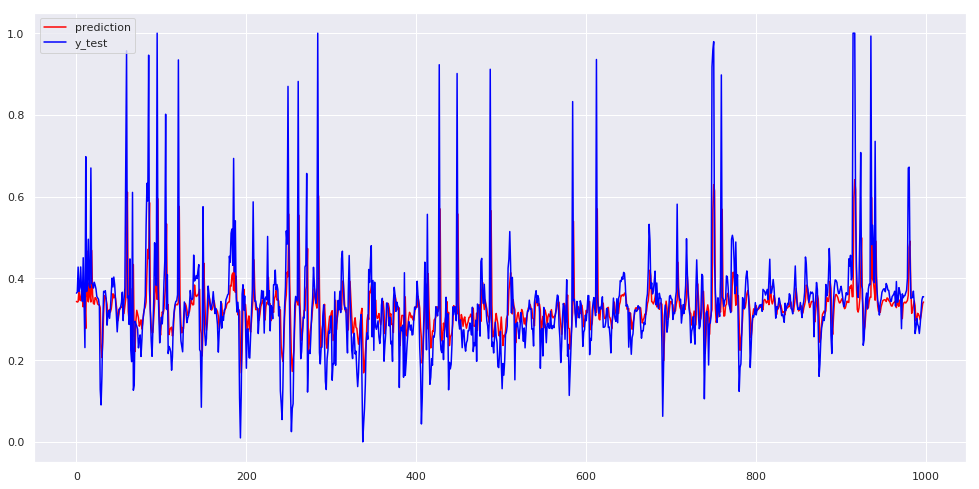

In [90]:
# plot the prediction and the reality (for the test data)
fig, axs = plt.subplots()
axs.plot(p,color='red', label='prediction')
axs.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()

In [91]:
# select the most distant prediction/reality data points as anomalies
diff = pd.Series(diff).astype(float)
number_of_outliers = int(0.01*len(diff))
threshold = diff.nlargest(number_of_outliers).min()
# data with anomaly label (test data part)
test = (diff >= threshold).astype(int)
# the training data part where we didn't predict anything (overfitting possible): no anomaly
#complement = pd.Series(0, index=np.arange(len(df)-testdatasize))
# # add the data to the main
#df['anomaly27'] = complement.append(test, ignore_index='True')
print(df['anomaly27'].value_counts())

NameError: name 'df' is not defined

In [ ]:
# plot the prediction and the reality (for the test data)
fig, axs = plt.subplots()
axs.plot(p,color='red', label='prediction')
axs.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = diff.nlargest(9)

ax.plot(y_test, color='blue')
ax.scatter(a.index, a, color='red')
plt.show()